In [1]:
import requests
import json
from tqdm.auto import tqdm
import math
import sqlite3
import re
from pymorphy2 import MorphAnalyzer
from string import punctuation
from nltk.tokenize import word_tokenize

morph = MorphAnalyzer()
import pandas as pd
from datetime import datetime

from numpy import mean
from collections import Counter
from nltk.corpus import stopwords

stopword_set = set(stopwords.words('russian'))

In [2]:
token = '0473668004736680047366809a04025ed900473047366805aef2eae538b1a27d99e05f7'
version = '5.92'

In [3]:
def get_n_of_posts(from_id=-25426051):
    data = requests.get(
        'https://api.vk.com/method/wall.get', 
        params={
            "owner_id": from_id,
            "count": 1,
            "v": version,
            "access_token": token

        }
    ).json()
    return data.get('response', {}).get('count')

def get_wall_posts_from_id(from_id=-25426051):
    n_posts = min(1000, get_n_of_posts(from_id=from_id))
    
    data = []
    for i in tqdm(range(math.ceil(n_posts / 100))):
        data2 = requests.get(
            'https://api.vk.com/method/wall.get', 
            params={
                "owner_id": -25426051,
                "count": 100,
                "offset": 100*i,
                "v": version,
                "access_token": token

            }
        ).json()
        data.extend(data2.get('response', {}).get('items', []))
    return data

def get_users_info(user):
    data = requests.get(
        'https://api.vk.com/method/users.get',
        params={
            'user_ids': signer_id,
            'fields': 'bday',
            'access_token': token,
            'v': version
        }
    ).json()

In [4]:
data = get_wall_posts_from_id(from_id=-57536014)

In [5]:
len(data)

1000

In [6]:
conn = sqlite3.connect('API.db')
c = conn.cursor()

In [7]:
c.execute("""CREATE TABLE IF NOT EXISTS POST(id integer PRIMARY KEY, 
            post text, lemmd text)""")

c.execute("""CREATE TABLE IF NOT EXISTS META(id integer PRIMARY KEY AUTOINCREMENT, 
             post_id integer, signer_id integer, likes integer, comments integer, date integer)""")

conn.commit()

In [8]:
to_df = []
for post in data:
    row = []
    row.append(post.get('id'))
    row.append(post.get('signer_id'))
    row.append(post.get('likes', {}).get('count', 0))
    row.append(post.get('comments', {}).get('count', 0))
    row.append(datetime.fromtimestamp(post.get('date')))
    to_df.append(row)

In [9]:
df = pd.DataFrame(to_df, columns=['id', 'signer_id', 'likes', 'comments', 'date'])
df = df.set_index('id')

In [10]:
df.head()

,signer_id,likes,comments,date
id,,,,
871602,7653689.0,1,0,2020-04-21 15:05:05
871588,192824717.0,0,0,2020-04-21 14:05:05
871573,17840103.0,37,8,2020-04-21 13:35:00
871560,NaN,0,0,2020-04-21 12:57:34
871531,32651317.0,26,10,2020-04-21 11:35:01


In [11]:
df.to_sql('META', conn, if_exists='replace')

In [12]:
to_2df = []
for post in data:
    row = []
    row.append(post.get('id'))
    row.append(post.get('text', ''))
    to_2df.append(row)   

In [13]:
df_2 = pd.DataFrame(to_2df, columns=['id', 'text'])
df_2 = df_2.set_index('id')

In [14]:
df_2['lemmatized'] = df_2.text.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))

In [15]:
df_2.head()

,text,lemmatized
id,,
871602,Отдаю за фрукты \nМетро Орехово \nПисать в лс\...,отдавать за фрукт метро орехово писать в лс фу...
871588,"Отдам даром пакет женской обуви на 35,36,37 ра...","отдать даром пакет женский обувь на 35,36,37 р..."
871573,"Отдам даром кошечку в хорошие руки, ей месяцев...",отдать даром кошечка в хороший рука она месяц ...
871560,,
871531,Кровать двуспальная 140х200 с 2 матрасами (тон...,кровать двуспальная 140х200 с 2 матрас тонкий ...


In [16]:
df_2.to_sql('POST', conn, if_exists='replace')

In [17]:
to_3df = []
for post in data:
    row = []
    row.append(post.get('id'))
    row.append(post.get('text', ''))
    post = [w for w in word_tokenize(post.get('text', '')) if not w in stopword_set]
    clear_post = ' '.join(post)
    row.append(clear_post)
    to_3df.append(row)

In [18]:
df_3 = pd.DataFrame(to_3df, columns=['id', 'text', 'text_wo'])
df_3 = df_3.set_index('id')
df_3['lemmd_text_wo'] = df_3.text_wo.apply(lambda x: ' '.join(morph.parse(w.strip(punctuation))[0].normal_form for w in x.split()))

In [19]:
del df_3['text_wo']

In [20]:
df_3.head() 

,text,lemmd_text_wo
id,,
871602,Отдаю за фрукты \nМетро Орехово \nПисать в лс\...,отдавать фрукт метро орехово писать лс футболк...
871588,"Отдам даром пакет женской обуви на 35,36,37 ра...","отдать даром пакет женский обувь 35,36,37 разм..."
871573,"Отдам даром кошечку в хорошие руки, ей месяцев...",отдать даром кошечка хороший рука месяц 6 её...
871560,,
871531,Кровать двуспальная 140х200 с 2 матрасами (тон...,кровать двуспальная 140х200 2 матрас тонкий т...


In [21]:
df_3.to_sql('WOS', conn, if_exists='replace')

In [22]:
conn.close()

### количество лайков по дате

Text(0.5, 1.0, 'количество лайков по дате')

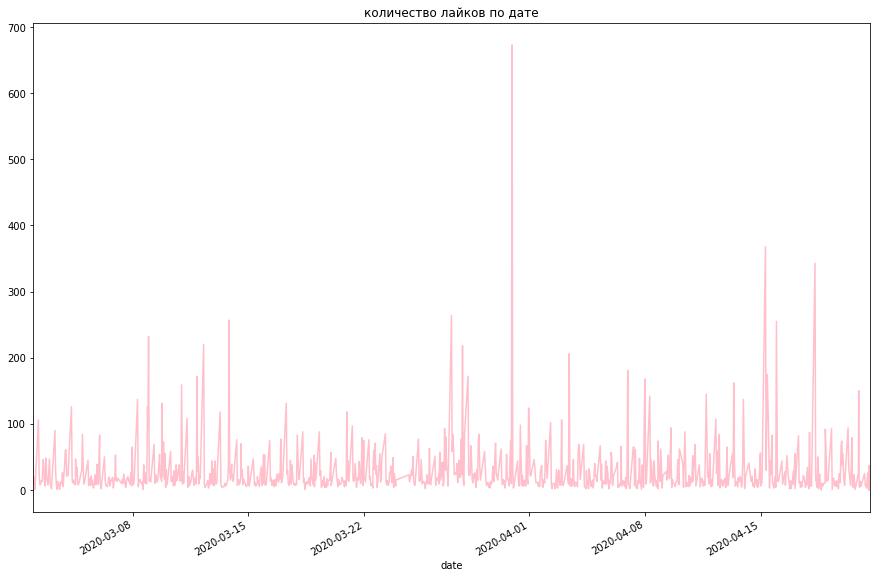

In [28]:
df = pd.DataFrame(to_df, columns=['id', 'signer_id', 'likes', 'comments', 'date'])
df = df.set_index('date')
plt = df.likes.plot(figsize=(15, 10), color='pink')
plt.set_title('количество лайков по дате')

Text(0.5, 1.0, 'количество комментариев по дате')

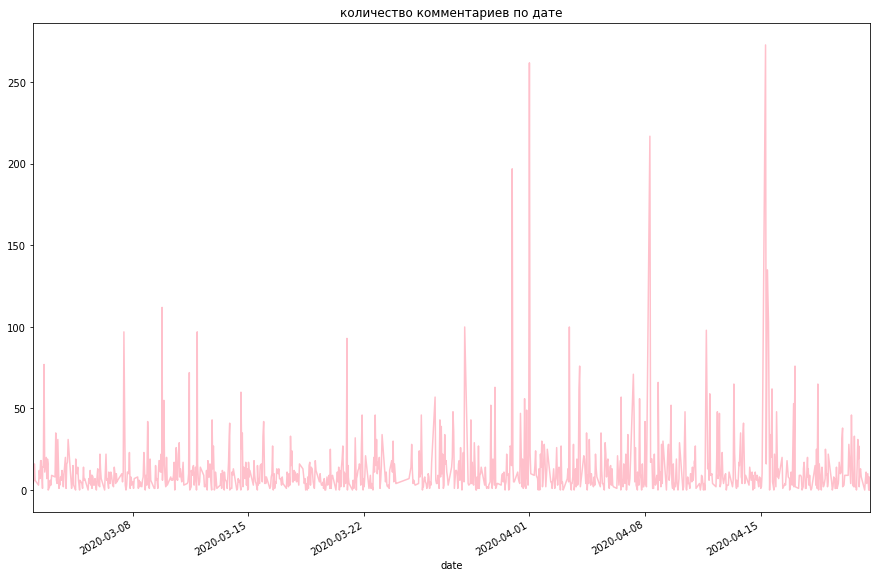

In [24]:
df = pd.DataFrame(to_df, columns=['id', 'signer_id', 'likes', 'comments', 'date'])
df = df.set_index('date')
plt = df.comments.plot(figsize=(15, 10), color='pink')
plt.set_title('количество комментариев по дате')

In [25]:
words = []
for cell in df_2['lemmatized'].values:
    words.extend([w for w in cell.split() if w not in stopword_set ])

In [26]:
dic = Counter(words).most_common(25)

Text(0.5, 1.0, '25 частотных слов')

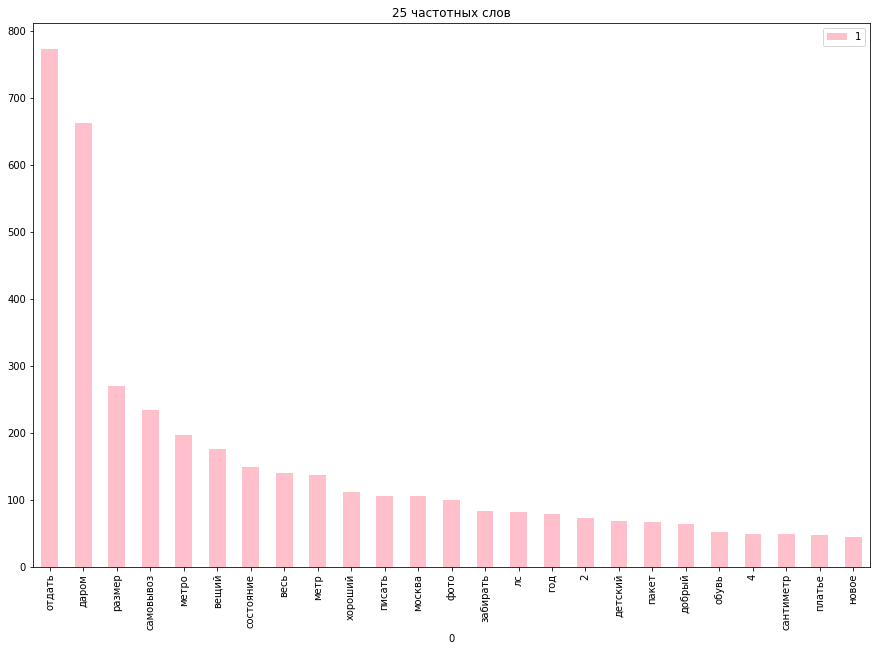

In [27]:
plt = pd.DataFrame(dic).set_index(0).plot(kind='bar', figsize=(15, 10), color='pink')
plt.set_title('25 частотных слов')